# Comparative analysis of image datasets for hand development and regeneration in salamanders.

+ Mean and std image of the dataset
+ Embedding the dataset using Resnet and UMAP

In [2]:
from pathlib import Path
from aicsimageio import imread
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.transform import resize

In [3]:
# Load png images from ./regeneration/ folder
# and convert to numpy array
data_dir = Path("../data/development&regeneration/")
image_shape = (128, 128)
images = {}
samples = ["development", "regeneration"]

for sample in samples:
    images[sample] = []
    img_dir = data_dir / sample
    print(img_dir)
    for file in img_dir.glob("*.png"):
        img = imread(file)
        # Mean rgb values
        img = img[0][0][0]
        img = np.mean(img, axis=2)
        # resize img to 128x128
        img = resize(img, output_shape=image_shape)
        images[sample].append(img)
    print(f"Number of images of {sample}: {len(images[sample])}")

..\data\development&regeneration\development
Number of images of development: 18
..\data\development&regeneration\regeneration
Number of images of regeneration: 50


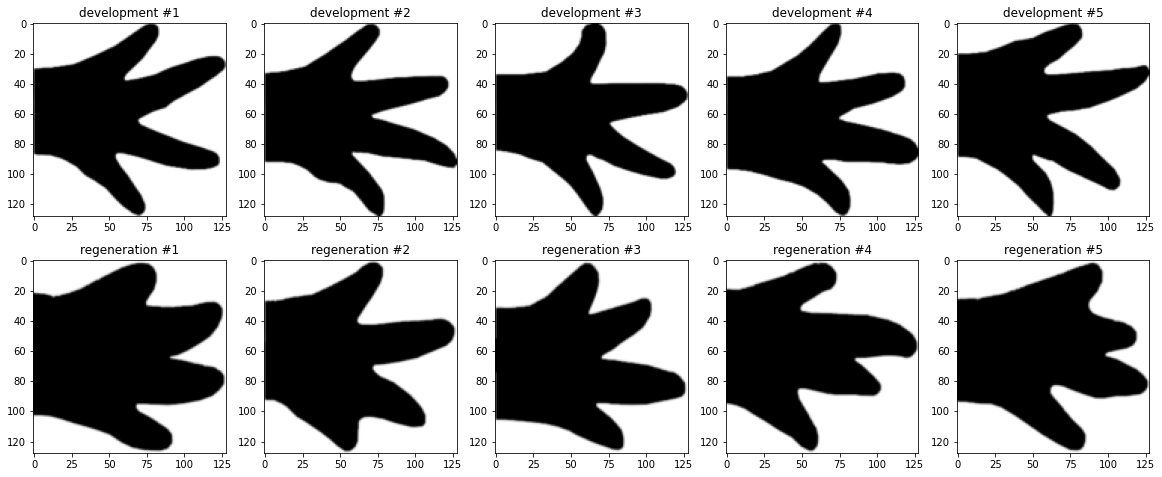

In [12]:
# display some images
n_col = 5
img_size = (4, 4)
fig, ax = plt.subplots(2, n_col, figsize=(img_size[0]*n_col, img_size[1]*2))
for col in range(n_col):
    for row, sample in enumerate(samples):
        ax[row, col].imshow(images[sample][col], cmap="gray")
        ax[row, col].set_title(f"{sample} #{col+1}")
fig.savefig("../figs/samples_development&regeneration.pdf")

Some sample images from the two sets of images (development and regeneration) can be displayed, which make it easier to observe the significant differences between them.

## Get mean image and compare between samples

In [5]:
# get mean images of images[sample]
mean_images = {}
for sample in samples:
    mean_images[sample] = np.mean(images[sample], axis=0)

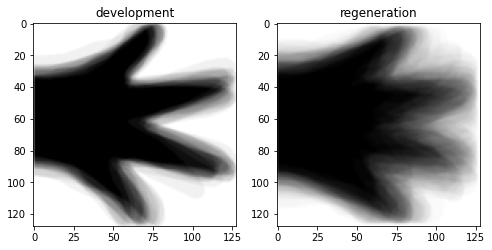

In [13]:
# display mean images
fig, ax = plt.subplots(1, 2, figsize=(img_size[0]*2, img_size[1]))
for row, sample in enumerate(samples):
    ax[row].imshow(mean_images[sample], cmap="gray")
    ax[row].set_title(sample)
fig.savefig("../figs/mean_images_development&regeneration.pdf")

The image on the left and right in the above picture show the average images of the salamander hand image dataset with normal development and tissue regeneration, respectively. It can be seen from the images that the tissues in normal development are more distinguishable between fingers, and overall changes are smaller.


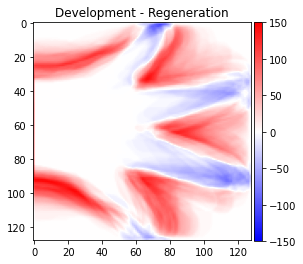

In [14]:
# make difference image
diff_image = mean_images["development"] - mean_images["regeneration"]
fig, ax = plt.subplots(1, 1, figsize=(img_size[0], img_size[1]))
ax.imshow(diff_image, cmap="bwr", vmax=150, vmin=-150)
ax.set_title("Development - Regeneration")
# draw colorbar
cax = fig.add_axes([0.9, 0.12, 0.03, 0.76])
cbar = fig.colorbar(ax.images[0], cax=cax)
fig.savefig("../figs/diff_image_development&regeneration.pdf")

The difference image between the average images of development and regeneration shows the specific regions of the regeneration image in red (value > 0), while the specific regions of the developmental image are in blue (value < 0).

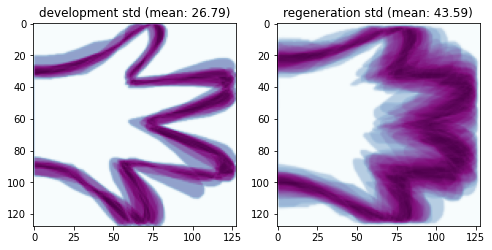

In [15]:
# get std images of images[sample]
std_images = {}
for sample in samples:
    std_images[sample] = np.std(images[sample], axis=0)

# display std images
fig, ax = plt.subplots(1, 2, figsize=(img_size[0]*2, img_size[1]))
for row, sample in enumerate(samples):
    ax[row].imshow(std_images[sample], cmap="BuPu")
    mean_std_val = np.mean(std_images[sample])
    ax[row].set_title(f"{sample} std (mean: {mean_std_val:.2f})")
fig.savefig("../figs/std_images_development&regeneration.pdf")

The standard deviation images of the development and regeneration datasets show that the areas with darker colors have greater variation between the images. It can be observed that the average pixel standard deviation in the developmental images (26.79) is significantly smaller than that in the regeneration images (43.59).

In [9]:
# reshape std images to 1D array and gather into a dataframe
df = pd.DataFrame()
for sample in samples:
    df[sample] = std_images[sample].reshape(-1)
df = df.melt()
df.columns = ["sample", "std"]
# remove small std values
threshold = 1
df = df[df["std"] > threshold]

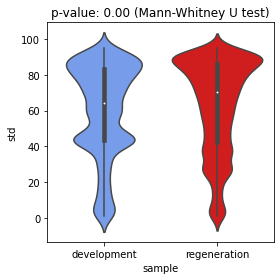

In [17]:
# draw violin plot and calculate p-value using ks-2samp
fig, ax = plt.subplots(1, 1, figsize=(img_size[0], img_size[1]))
# chage color of violin plot (red and blue)
sns.set_palette(sns.color_palette(["#6495FD", "#EE0000"]))
sns.violinplot(data=df, x="sample", y="std", ax=ax)
p_val = mannwhitneyu(df[df["sample"] == "development"]["std"], df[df["sample"] == "regeneration"]["std"])[1]
ax.set_title(f"p-value: {p_val:.2f} (Mann-Whitney U test)")
plt.tight_layout()
fig.savefig("../figs/std_violin_development&regeneration.pdf")

Violin plot of the pixel differences in standard deviation images between development and regeneration images shows that the pixel std in regeneration images is higher overall. The difference is extremely significant according to Mann-Whitney U test (p-value = 0.0).

## Embedding analysis

Create embedding of images using Resnet-18, and then use UMAP to reduce the dimensionality of the embedding to 2D.

In [100]:
import torch
from torchvision.models import resnet18
import torch.nn as nn

model = resnet18(pretrained=True)
model.fc = nn.Identity()  # replace fully connected layer with identity function

def embedding_img(img):
    img_ = np.stack([img, img, img])
    img_ = img_.astype(np.float32)
    img_ = torch.from_numpy(img_)
    img_ = torch.unsqueeze(img_, 0)
    return model(img_).detach().numpy().reshape(-1)

c:\Users\Nangu\miniconda3\envs\qt\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Nangu\miniconda3\envs\qt\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [101]:
# embedding all images
embeddings = {}
for sample in samples:
    embeddings[sample] = []
    for img in images[sample]:
        embeddings[sample].append(embedding_img(img))

In [102]:
# reduce dimension of embeddings using UMAP
import umap.umap_ as umap
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = {}
for sample in samples:
    embedding_2d[sample] = reducer.fit_transform(embeddings[sample])

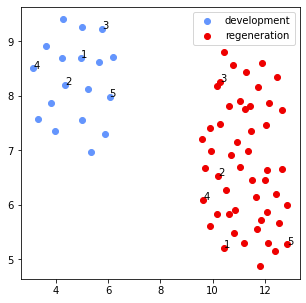

In [107]:
# draw scatter plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for sample in samples:
    ax.scatter(embedding_2d[sample][:, 0], embedding_2d[sample][:, 1], label=sample)
ax.legend()
# mark first 5 images on each sample, with NO of images
for sample in samples:
    for i in range(5):
        ax.annotate(f"{i+1}", (embedding_2d[sample][i, 0], embedding_2d[sample][i, 1]))
fig.savefig("../figs/embedding_2d_development&regeneration.pdf")